# Teaching Demo — Clustering

Bill Quinn<br>May 10, 2022

In [1]:
%%time

# Make sure constellate is installed and begin downloading toy dataset.
# This may take a few minutes the first time.
import constellate

dataset_id = '7e41317e-740f-e86a-4729-20dab492e925'

dataset_file = constellate.download(dataset_id, 'jsonl')

Constellate: use and download of datasets is covered by the Terms & Conditions of Use: https://constellate.org/terms-and-conditions/
All documents from JSTOR published in Shakespeare Quarterly from 1950 - 2020. 6745 documents.
INFO:root:File /Users/quinn.wi/data/7e41317e-740f-e86a-4729-20dab492e925.jsonl.gz exists. Not re-downloading.
CPU times: user 74.5 ms, sys: 20.3 ms, total: 94.9 ms
Wall time: 392 ms


## Clustering Overview

### What is clustering?

In simple terms, clustering is a machine learning process that tries to divide a dataset into groups, or clusters. The process organizes these clusters based on whether they share similar features to each other. For our purposes, documents that share similar words will cohere around a point (known as a centroid) and dissimilar documents will move away from that point (and make their own centroid elsewhere). Clustering is an unsupervised process, which means we don't need to supply annotations or labels. All we need is the data (the text in this case). 

More specifically, we will be using Principal Component Analysis and KMeans Clustering to do this task. Rather than get bogged down on these technical terms, however, we will define them when we use them. The transformations that create can be more intuitive than their definitions.

![CESTA Flight Clustering](assets/images/Schmidt_CESTA-clustering.png "CESTA Flight Clustering - Ben Schmidt")
> [CESTA Flight Clusters by Ben Schmidt](https://benschmidt.org/HDA/clustering.html)

### Why use clustering?

Clustering can be an effective way to explore a dataset and discover inherent patterns. These patterns might reveal something about our dataset we couldn't perceive from reading or might prompt further questions about things we suspected but didn't know.

### The goal of this notebook.

My hope is that this notebook will serve as a template for transforming data and clustering it. While our focus will be on clustering data, converting text data to a numerical matrices has broad applicability. The first half of this notebook can be a jumping off point for other machine learning processes, especially from the SciKit-Learn library.

### What to expect from this notebook.

<b>Audience:</b> `Teachers` / `Learners` / `Researchers`

<b>Use Case:</b> `How-To`

This notebook offers a recipe of parts that guides the user through the steps involved in addressing key problems and use-cases. More advanced than tutorials and assumes more basic knowledge. A How-To may use toy examples, but it also gives perspective on how to adapt a process to other common issues or data.

<b>Difficulty:</b> `Advanced`

Advanced assumes users are very familiar with Python and have been programming for years, but they may not be familiar with the process being explained. 

> If this sounds intimidating, though, I hope you'll stick around! I've learned advanced skills by playing with libraries and methods I was unfamiliar with just to see what I'd find. I think breaking, fixing, and playing are the best ways to learn code. Additionally, "stealing" code is writing code, so please take whatever you need from this notebook and adapt the rest!

<b>Completion Time:</b> `60 minutes`

<b>Knowledge Required:</b>
- Python basics (variables, flow control, functions, loops, and conditions) 
- Basic data structures and types (lists, dictionaries, strings, and integers)
- A general understanding of TF-IDF and what it does.

<b>Knowledge Recommended:</b>
- Basic understanding of dataframes and `Pandas`.
- Familiarity with using libraries.

<b>Learning Objectives:</b>
- Describe clustering and why/when to implement it.
- Transform text data into TF/IDF and re-join with metadata.
- Find the principal components of a data set, TF/IDF in this case.
- Visualize clusters of documents as scatter plot.

<b>Research Pipeline:</b>
- Before working through this notebook, it could be helpful to review TF/IDF and working with Constellate data.
    - Much of this workshop builds off of [Finding Significant Words using TF/IDF](https://constellate.org/tutorials/finding-significant-terms)
- This notebook will provide a template for transforming text data to a TF/IDF matrix and using that matrix for clustering.
- After working through this notebook, try creating a new notebook and clustering a different data set.
    - I recommended always typing code by hand rather than copying-and-pasting. While tedious, working through code slowly can help it stick better.
- Once you have the code working on your own dataset, I suspect you might have more questions about why your data was sorted the way it was and invite you to further explore machine learning methods.

### Required Libraries

In addition to using `Pandas`, `numpy`, and `matplotlib`, which should be included when you installed Jupyter Notebook, we will also be using the following libraries. If you haven't used these before you can install them by copying and pasting these commands in your <b>Terminal (Mac)</b> or <b>Command Prompt (Windows)</b>.

- <b>Constellate Client:</b> `pip install constellate-client`
    - [Constellate Documentation](https://constellate.org/docs/topic/reference)
- <b>scikit-learn:</b> `conda install -c anaconda scikit-learn`
    - [scikit-learn Documentation](https://scikit-learn.org/stable/)
- <b>Seaborn:</b> `conda install -c anaconda seaborn`
    - [Seaborn Documentation](https://seaborn.pydata.org/)

## The Code

### Importing Libraries

In [2]:
import constellate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Scikit Learn (sklearn).
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Import Seaborn for visualizations.
import seaborn as sns

> <b>Tip:</b> To see line numbers in a code cell, press Esc. then L.

### Importing Data from Constellate

In [3]:
%%time

import constellate

# Feel free to change the dataset_id to another id.
dataset_id = '7e41317e-740f-e86a-4729-20dab492e925'

dataset_file = constellate.download(dataset_id, 'jsonl')

All documents from JSTOR published in Shakespeare Quarterly from 1950 - 2020. 6745 documents.
INFO:root:File /Users/quinn.wi/data/7e41317e-740f-e86a-4729-20dab492e925.jsonl.gz exists. Not re-downloading.
CPU times: user 13.7 ms, sys: 2.49 ms, total: 16.2 ms
Wall time: 159 ms


> <b>Tip:</b> I like to use `%%time`, which is called a "magic command," to measure how long a cell takes. This can be helpful if I need to interrupt a cell. The black square just below "Kernel" at the top of the page will stop a cell. This is useful if I suspect a code block is taking too long and needs to be reviewed.

#### Create functions for cleaning data

In [4]:
%%time

# Define a function that will process individual tokens
# Only a token that passes through all three `if` 
# statements will be returned. A `True` result for
# any `if` statement does not return the token.

def process_token(token):
    token = token.lower()
    if len(token) < 4: # If True, do not return token
        return None
    
    if not(token.isalpha()): # If True, do not return token
        return None
    
    return token # If all are False, return the lowercased token

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


#### Read in data and select some metadata

In [5]:
%%time

# Create an empty list to hold documents.
dataframe = []

# Loop through each document.
for document in constellate.dataset_reader(dataset_file):
    
    doc_data = {} # Create an empty dictionary to hold all information about a single document.
    
    doc_data['id'] = document['id'] # Add key and value the document's id to dataframe dictionary.
    doc_data['title'] = document['title']
    doc_data['publisher'] = document['publisher']
    doc_data['publicationYear'] = document['publicationYear']
    
#     Keep data if the publicationYear is later than 1990 and the article isn't a review.
    if document['publicationYear'] >= 1990 and doc_data['title'] != 'Review Article':
        
        processed_document = []
        unigrams = document.get('unigramCount', [])
        for gram, count in unigrams.items():
            clean_gram = process_token(gram)
            if clean_gram is None:
                continue

            processed_document += [clean_gram] * count 

        doc_data['text'] = processed_document # Add text to dictionary.

        dataframe.append(doc_data) # Append document dictionary to dataframe list.
    
#     Otherwise, ignore and pass to the next.
    else:
        pass
        
# Convert list of dictionaries to dataframe.     
dataframe = pd.DataFrame(dataframe)

# Convert list of unigrams in the 'text' field to string.
dataframe['text'] = dataframe['text'].apply(lambda x: ' '.join(x))

dataframe.head()

CPU times: user 24.2 s, sys: 396 ms, total: 24.6 s
Wall time: 24.9 s


,id,title,publisher,publicationYear,text
0,http://www.jstor.org/stable/24778460,"""The Killing Stops Here"": Unmaking the Myths o...",Folger Shakespeare Library,2013,killing stops unmaking myths troy troy wooster...
1,http://www.jstor.org/stable/2870867,The Shenandoah Shakespeare Express,Folger Shakespeare Library,1992,shakespeare shakespeare shakespeare shakespear...
2,http://www.jstor.org/stable/2871295,Retrieving Jonson's Petrarch,Folger Shakespeare Library,1994,retrieving petrarch petrarch petrarch petrarch...
3,http://www.jstor.org/stable/3844072,"Shakescorp ""Noir""",Folger Shakespeare Library,2002,shakescorp noir douglas douglas lanier lanier ...
4,http://www.jstor.org/stable/2871279,Glass Slippers and Seven-League Boots: C-Promp...,Folger Shakespeare Library,1997,glass slippers doubts about ascribing funeral ...


#### Examine Document Metadata Fields

In [6]:
%%time

print ('"Keys" of Each Document')

for k in document.keys():
    print ('\t-', k)

"Keys" of Each Document
	- id
	- docType
	- title
	- creator
	- isPartOf
	- sourceCategory
	- pageStart
	- url
	- volumeNumber
	- issueNumber
	- language
	- pageEnd
	- pageCount
	- pagination
	- datePublished
	- publicationYear
	- publisher
	- wordCount
	- provider
	- outputFormat
	- identifier
	- unigramCount
	- bigramCount
	- trigramCount
CPU times: user 1.5 ms, sys: 1.28 ms, total: 2.79 ms
Wall time: 1.85 ms


## Find TF-IDF of Documents

In [7]:
%%time

# Instantiate a vectorizer. 
tfidf = TfidfVectorizer(
    min_df=0.05, 
    max_df=0.9,
    stop_words='english',
    encoding='latin-1'
)

# The features are a matrix.
features = tfidf.fit_transform(dataframe['text']).toarray()

# Show data size.
print (features.shape)

(938, 5669)
CPU times: user 2.21 s, sys: 38.6 ms, total: 2.25 s
Wall time: 2.28 s


## Preparing the Data

We are trying to create a matrix: rows and columns with numerical values. More specifically, each row of this matrix will represent a document and the columns will represent the frequency (TF-IDF) of a specific word. We can achieve this transformation by separating out our metadata and then re-shaping the dataframe. Many computational processes expect a matrix-like input. The following code-block, then, can be a useful reference for other projects as well.

In [8]:
%%time

# Create new dataframe with features, using original 'dataframe' index.
doc_data = pd.DataFrame(features,
                        index = dataframe.index,
                        columns = tfidf.get_feature_names())

doc_data.head(3)

CPU times: user 5.14 ms, sys: 2.77 ms, total: 7.91 ms
Wall time: 7.02 ms


,aaron,abandon,abandoned,ability,able,ably,abraham,absence,absent,absolute,...,years,yellow,yield,yields,york,yorkshire,young,younger,youth,youthful
0,0.0,0.0,0.0,0.000000,0.022407,0.021964,0.0,0.000000,0.000000,0.0,...,0.029897,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.018231,0.000000,0.000000,0.0,0.000000,0.023387,0.0,...,0.013681,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.038370,0.032371,0.000000,0.0,0.038306,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.094244,0.0,0.0,0.0,0.0,0.0


#### Re-Join Features with Metadata

In [9]:
%%time

# Re-join features dataframe with metadata.
# Drop text column now that we have features.
dataframe = dataframe \
    .drop(columns = ['text']) \
    .merge(doc_data, left_index=True, right_index=True, how = 'inner') # merge data where left and right indices match.

dataframe.head(3)

CPU times: user 31.7 ms, sys: 11.5 ms, total: 43.2 ms
Wall time: 41.5 ms


,id,title_x,publisher_x,publicationYear,aaron,abandon,abandoned,ability,able,ably,...,years,yellow,yield,yields,york,yorkshire,young,younger,youth,youthful
0,http://www.jstor.org/stable/24778460,"""The Killing Stops Here"": Unmaking the Myths o...",Folger Shakespeare Library,2013,0.0,0.0,0.0,0.000000,0.022407,0.021964,...,0.029897,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,http://www.jstor.org/stable/2870867,The Shenandoah Shakespeare Express,Folger Shakespeare Library,1992,0.0,0.0,0.0,0.018231,0.000000,0.000000,...,0.013681,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,http://www.jstor.org/stable/2871295,Retrieving Jonson's Petrarch,Folger Shakespeare Library,1994,0.0,0.0,0.0,0.038370,0.032371,0.000000,...,0.000000,0.0,0.0,0.0,0.094244,0.0,0.0,0.0,0.0,0.0


> <b>Tip:</b> We can use `\` at the end a line and start a new line. This helps with readability.

When merging the two dataframes (features and metadata), pandas found two columns with the same name: title. One refers to the metadata, the title of the article. The other refers to the word "title" as it appears within the article. Pandas distinguishes between the two by adding "_x" to the first.

In [10]:
%%time

# Rename column for clarity.
dataframe = dataframe.rename(columns = {'title_x': 'meta_title', 'publisher_x': 'meta_publisher'})

dataframe.head(2)

CPU times: user 30.6 ms, sys: 23.1 ms, total: 53.7 ms
Wall time: 52.6 ms


,id,meta_title,meta_publisher,publicationYear,aaron,abandon,abandoned,ability,able,ably,...,years,yellow,yield,yields,york,yorkshire,young,younger,youth,youthful
0,http://www.jstor.org/stable/24778460,"""The Killing Stops Here"": Unmaking the Myths o...",Folger Shakespeare Library,2013,0.0,0.0,0.0,0.000000,0.022407,0.021964,...,0.029897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,http://www.jstor.org/stable/2870867,The Shenandoah Shakespeare Express,Folger Shakespeare Library,1992,0.0,0.0,0.0,0.018231,0.000000,0.000000,...,0.013681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Scale Data

Scaling data is a crucial step when using most kinds of machine learning methods. Scaling is a process that standardizes the values of a matrix (the tf/idf values of our words' columns). This is an important step because it prevents outliers, values with a very high or low value, from skewing our data. 

In [11]:
%%time

# Overwrite features data with scaled version.
features = StandardScaler() \
    .fit_transform(features)

features

CPU times: user 77.9 ms, sys: 10.1 ms, total: 88 ms
Wall time: 86.5 ms


array([[-0.16211207, -0.22472067, -0.23558933, ..., -0.25600675,
        -0.26062388, -0.17807122],
       [-0.16211207, -0.22472067, -0.23558933, ..., -0.25600675,
        -0.26062388, -0.17807122],
       [-0.16211207, -0.22472067, -0.23558933, ..., -0.25600675,
        -0.26062388, -0.17807122],
       ...,
       [-0.16211207, -0.22472067, -0.23558933, ..., -0.25600675,
        -0.26062388, -0.17807122],
       [-0.16211207, -0.22472067, -0.23558933, ...,  0.18059156,
        -0.26062388, -0.17807122],
       [-0.01826955, -0.22472067, -0.15242352, ..., -0.17627247,
         0.29642294,  0.01467327]])

It can be difficult to read, but `features` is now an array (or matrix). It has retained the same shape of rows and columns as before, but now that we've scaled the data, the values are compressed to avoid skewing too far in any direction.

## Principal Component Analysis (PCA)

Principal component analysis is a method to reduce data so it can be represented in two- or three-dimensional space. This is referred to as <b>dimensionality reduction</b> But, what does that mean? Currently, our data has 5,670 dimensions that we're interested in: all the word columns minus the three metadata fields. While the computer can hold all the dimensions in memory, I can't. So, PCA is a way to cut away data that it believes is unnecessary for distinguishing between observations.

![PCA Simplified](assets/images/PCA_simplified.png "PCA Simplified")

How does it determine which columns (words) are more useful for distinguishing between documents, though? PCA looks at each column and finds the column with the greatest variance. That is, the column with the largest range of values. The actual math that finds variation is much more complicated than this, but, for our purposes, we only need to grasp the fundamental transformation.

In [12]:
%%time

# We'll instantiate a PCA model and limit it to two principal components.
pca = PCA(n_components = 2)

# We'll fit the now-scaled features to the PCA model.
components = pca.fit_transform(features)

# We'll then convert to a dataframe, still using the same index of our original dataframe.
pcaDF = pd.DataFrame(data = components, 
                           columns = ['pc1', 'pc2'],
                           index = dataframe.index)

pcaDF.head()

CPU times: user 505 ms, sys: 33.2 ms, total: 538 ms
Wall time: 124 ms


,pc1,pc2
0,9.249441,5.596490
1,5.574416,9.926156
2,-1.292714,2.182451
3,10.189810,-4.105580
4,5.923143,0.805478


We now have the principal components of our dataset and reduced our 5,670 dimensions to just two. While this may seem like a loss of information, it's often necessary for us to make sense of our data.

One thing we could do is re-join the words with their principal components. This would show use which words played a big role in determining the similarity of each document.

In [13]:
%%time

# Get the most important features and their names for each component.
most_important_feats = [np.abs(pca.components_[i]).argmax() for i in range(2)]

feat_names = tfidf.get_feature_names()

most_important_words = [feat_names[most_important_feats[i]] for i in range(2)]

# Join most important words with their component.
feat_dict = {'PC{}'.format(i): most_important_words[i] for i in range(2)}

feat_df = pd.DataFrame(feat_dict.items())

# Show dataframe.
feat_df

CPU times: user 30.8 ms, sys: 1.13 ms, total: 31.9 ms
Wall time: 5.42 ms


,0,1
0,PC0,university
1,PC1,production


But, these new information still doesn't provide us with much information we can interpret. That is, we still can't see any clusters.

## Visualize

Fortunately, we can treat our first and second principal components as x and y coordinates. This way we can visualize each document as a point in a scatterplot.

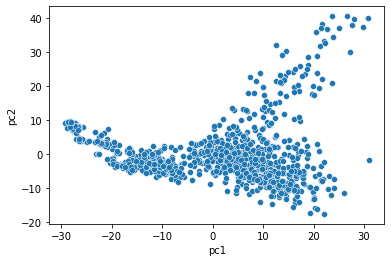

CPU times: user 762 ms, sys: 15.5 ms, total: 777 ms
Wall time: 131 ms


In [14]:
%%time

# Sns (seaborn) is a simple and lightweight visualization library, which makes it useful for data exploration.
sns.scatterplot(
    data = pcaDF,
    x = 'pc1', y = 'pc2'
)

# We'll call plt (matplotlib) to show the plot below.
plt.show()

## Clustering

We have now reduced our data to two dimensions and plotted into 2d space. But, we still can't quite see clusters. We could try to eye-ball in, but this wouldn't be precise and would make referencing nearly impossible.

Instead, we can use k-means clustering. K-means clustering attempts to partition data points into different groups. These clusters are determined by how close a datapoint is to the nearest mean of a cluster. As we'll see, we set how many clusters we want the algorithm to find. It then takes a look at every data point and places each cluster's centroid (the mean) within the datapoints. The datapoints then join the closest centroid and form a cluster.

Again, the math is more complicated here but we're focused on the transformation itself.

In [15]:
%%time

model = KMeans(n_clusters = 5, random_state = 0) 

predictions = model.fit_predict(components)

pcaDF['meta_cluster'] = predictions # append cluster predictions to principal components.
pcaDF['meta_publisher'] = dataframe['meta_publisher'] # include publisher if you want to visualize that instead.

CPU times: user 189 ms, sys: 12.9 ms, total: 202 ms
Wall time: 56.8 ms


#### Append Cluster Labels to Dataframe

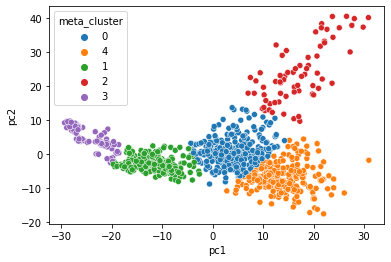

CPU times: user 726 ms, sys: 16.7 ms, total: 743 ms
Wall time: 187 ms


In [16]:
%%time

# Seaborn will read the labels as numerical and apply a gradient color scheme.
# Instead, we want to treat the labels as categorical, so we will change them from integers to strings.
pcaDF['meta_cluster'] = pcaDF['meta_cluster'].astype(str)

sns.scatterplot(
    data = pcaDF,
    x = 'pc1', y = 'pc2',
    hue = 'meta_cluster'
)

plt.show()

We can now see five groups within our dataset. As an exploration, we can begin to describe some patterns. This hopefully will lead us to more questions and move us from exploration to data analysis. Do these clusters describe some large practice within the scholarship of the journal? What happens if we add earlier documents and used the publicationYear to color each datapoint? 

## Conclusion

The methods used in this notebook are specific to PCA and K-Means clustering. But, the data transformations we used to get there make it applicable to other machine learning processes as well. We can, therefore, repeat the first half of this notebook and use our familiarity with scikit-learn now to try out other methods!